<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101204
Name = 'MohammadParsa'
Last_Name = 'Dini'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Importing Libraries

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [3]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:16<00:00, 1645514.12it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 191750.19it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1350768.61it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4011942.96it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [5]:
## FILL HERE

# FashionMNIST dataset information
num_classes = len(set(train_set.targets.numpy()))
# Calculating input dimension of the first layer
input_dim = train_set[0][0].shape[1] * train_set[0][0].shape[2]

print("Number of classes:", num_classes)
print("Input dimension of the first layer:", input_dim)


# so the images' sizes are 28*28 pixels

Number of classes: 10
Input dimension of the first layer: 784


In [6]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

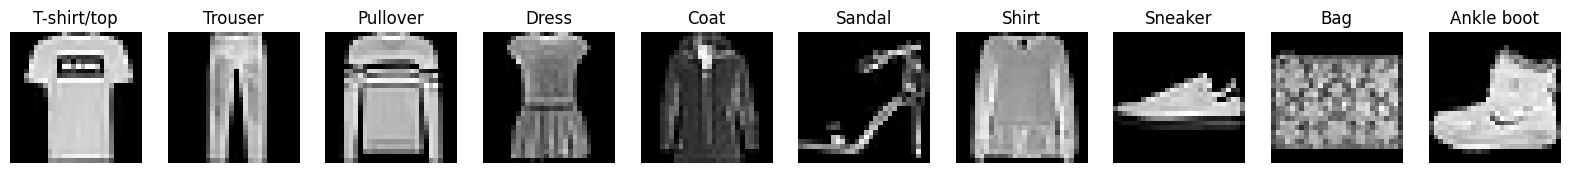

In [7]:
# Function to visualize 1 random image from each class
def visualize_random_images(dataset):
    # Get the mapping from class names to indices
    class_to_idx = dataset.class_to_idx
    # Create a reverse mapping from indices to class names
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Create a figure with subplots for each class
    fig, axs = plt.subplots(1, num_classes, figsize=(20, 5))

    sampled = set()  # Set to keep track of sampled classes
    for i in range(len(dataset)):
        img, label = dataset[i]  # Get the image and label
        if label not in sampled:
            # Display the image in the corresponding subplot
            axs[label].imshow(img.squeeze(), cmap='gray')
            axs[label].set_title(idx_to_class[label])  # Set the title to the class name
            axs[label].axis('off')  # Turn off the axis
            sampled.add(label)  # Add the label to the sampled set
            if len(sampled) == num_classes:
                break  # Stop if all classes have been sampled
    plt.show()  # Display the plot

# Visualize 1 random image from each class for the train set
visualize_random_images(train_set)


## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [8]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [9]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [11]:
def affine_forward(x, w, b):
    # out = x.mm(w.t()) + b
    # this dot did not work out well so I
    out = torch.mm(x, w) + b

    return out

    ## FILL HERE


def relu(x):
    return torch.max(torch.tensor(0, dtype=x.dtype, device=x.device), x)
    ## FILL HERE

Function `model` returns output of the whole model for the input `x` using the parameters:

In [12]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # Get the number of batches
    B = x.shape[0]
    # Flatten the input tensor
    x = x.view(B, -1)
    # Loop through the layers, except the last one
    for i in range(num_layers-1):
        # Apply affine transformation
        x = affine_forward(x, parameters[f'w{i}'], parameters[f'b{i}'])
        # Apply ReLU activation function
        x = relu(x)

    # Apply affine transformation for the last layer
    output = affine_forward(x, parameters[f'w{num_layers-1}'], parameters[f'b{num_layers-1}'])

    return output


Implementing cross entropy loss:

In [13]:

def cross_entropy_loss(scores, y):
    n = len(y)
    exp_scores = torch.exp(scores)
    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    correct_logprobs = -torch.log(probs[range(n), y])
    loss = torch.sum(correct_logprobs) / n
    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [14]:
def sgd_optimizer(parameters: dict, learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''

    for param in parameters.values():
        param.data -= learning_rate * param.grad

    # Zero gradients
    for param in parameters.values():
        param.grad = None

Training functions:

In [18]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    acc = np.mean(y_pred == y_true)

    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []


    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE


        loss = cross_entropy_loss(p, y)
        train_loss += loss.item()

        loss.backward()
        sgd_optimizer(parameters, learning_rate)


        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch

    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE
        # computing the loss
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [17]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [20]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        test_loss, test_acc = validate(test_loader, epoch, set_name='test')

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)


    # Plot the loss history of training and test sets
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.grid()
    plt.legend()

    # Plot the accuracy history of training and test sets
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.grid()
    plt.legend()

    plt.show()


Accuracy of train set: 0.27631666666666665
Accuracy of test set: 0.2982666666666667
Accuracy of train set: 0.28078333333333333
Accuracy of test set: 0.2938
Accuracy of train set: 0.5020166666666667
Accuracy of test set: 0.5905333333333334
Accuracy of train set: 0.64775
Accuracy of test set: 0.6625166666666666
Accuracy of train set: 0.7045333333333333
Accuracy of test set: 0.7163333333333334
Accuracy of train set: 0.7352333333333333
Accuracy of test set: 0.7509833333333333
Accuracy of train set: 0.7546166666666667
Accuracy of test set: 0.7714833333333333
Accuracy of train set: 0.7715
Accuracy of test set: 0.76655
Accuracy of train set: 0.7839833333333334
Accuracy of test set: 0.78015
Accuracy of train set: 0.7965166666666667
Accuracy of test set: 0.7875
Accuracy of train set: 0.80555
Accuracy of test set: 0.7874333333333333
Accuracy of train set: 0.81365
Accuracy of test set: 0.8193333333333334
Accuracy of train set: 0.8193
Accuracy of test set: 0.82865
Accuracy of train set: 0.82428333

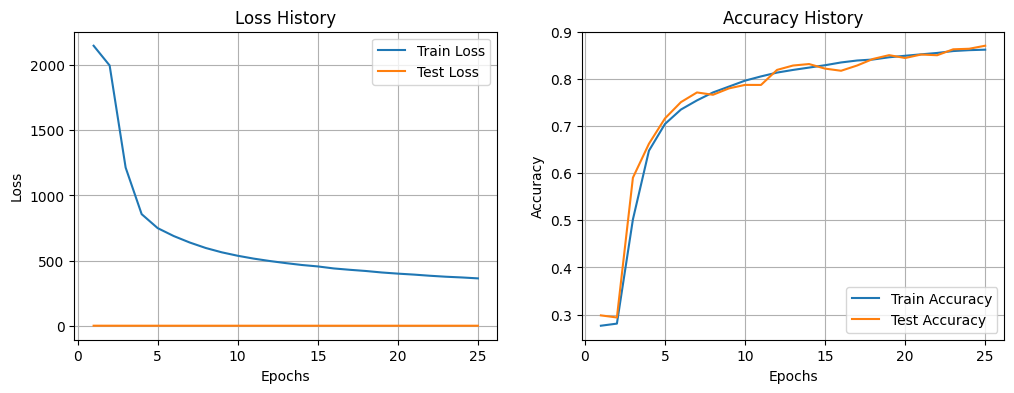

In [21]:
# here we decided that 25 epochs along with 0.005 learning rate is sufficient

train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

# As you see, the accuracy of the train/test set increases as training continues...

In [22]:
print('--------------------------------------------------')
print(f'Final test accuracy: {test_accuracies[-1]}')
print('--------------------------------------------------')
# accuracy which is good
#

--------------------------------------------------
Final test accuracy: 0.8706833333333334
--------------------------------------------------


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

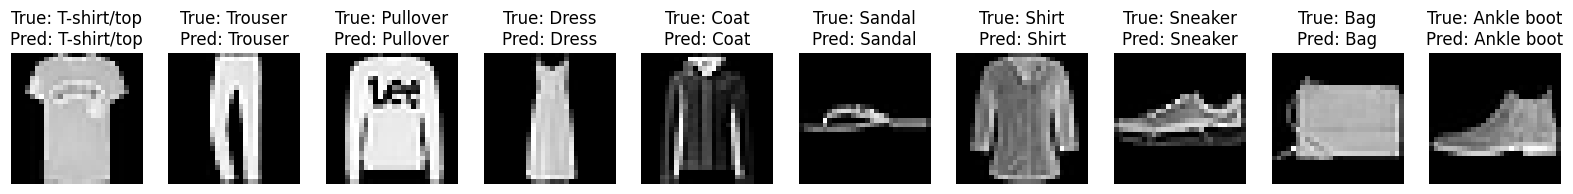

In [23]:
def visualize_predictions(dataset, parameters, num_classes=num_classes):
    # Get the mapping from class names to indices
    class_to_idx = dataset.class_to_idx
    # Create a reverse mapping from indices to class names
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Create a figure with subplots for each class
    fig, axs = plt.subplots(1, num_classes, figsize=(20, 5))

    # Set to keep track of sampled classes
    sampled = set()
    for i in range(len(dataset)):
        # Get the image and label from the dataset
        img, label = dataset[i]
        # Check if the class has already been sampled
        if label not in sampled:
            # Add a batch dimension and move to the appropriate device
            img_tensor = img.unsqueeze(0).to(device)
            with torch.no_grad():
                # Get the model's output
                output = model(img_tensor, parameters)
                # Get the predicted label
                predicted_label = output.argmax(dim=-1).item()

            # Display the image and the true and predicted labels
            axs[label].imshow(img.squeeze(), cmap='gray')
            axs[label].set_title(f'True: {idx_to_class[label]}\nPred: {idx_to_class[predicted_label]}')
            axs[label].axis('off')
            # Mark this class as sampled
            sampled.add(label)
            # Stop if all classes have been sampled
            if len(sampled) == num_classes:
                break

    # Show the plot
    plt.show()

# Call the function to visualize predictions
visualize_predictions(test_set, parameters)
